In [1]:
%load_ext autoreload
%autoreload 2

# Assignment 1

# Density estimation using Real NVP

Normalizing flows are the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to training a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below. 

<img src="2d-example.png" width=600px>


#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution on $X$ by
\begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align}
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density on a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
\begin{align}
y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big),
\end{align}

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on 2d circles or moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib).
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [2]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
import numpy as np

In [3]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        
        x = z
        for i in range(len(self.mask)-1,-1,-1):
            xx = x*self.mask[i][np.newaxis,:] 
            x = xx + (1-self.mask[i])*(x - self.t[i](xx))*torch.exp(-self.s[i](xx))
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        log_det_J = 0
        z = torch.Tensor(x)
        for s, t, mask in zip(self.s, self.t, self.mask):
            zz = mask[np.newaxis, :] * z # batchSize x dim(X)
            ss= (1-mask)*s(zz)
            tt = (1-mask)*t(zz)
            z = zz + (1-mask)*z*torch.exp(ss) + tt
            log_det_J += ss.sum(dim=-1)
            
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        
        return logp
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        z = prior.sample((batchSize,))
        x = self.g(z)
        return x

In [4]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 16, 16)

def flatt(x):
    #print(x.size())
    return x.view(-1,144)

nets = lambda: nn.Sequential(nn.Linear(2,64), nn.ReLU(), nn.Linear(64,128), nn.ReLU(), nn.Linear(128,256), nn.ReLU(), Lambda(preprocess),\
                             nn.Conv2d(1,2,4), nn.ReLU(), nn.Conv2d(2,1,2), Lambda(flatt),\
                            nn.ReLU(), nn.Linear(144,2))
nett = lambda: nn.Sequential(nn.Linear(2,64), nn.ReLU(), nn.Linear(64,128), nn.ReLU(), nn.Linear(128,256), nn.ReLU(), Lambda(preprocess),\
                             nn.Conv2d(1,2,4), nn.ReLU(), nn.Conv2d(2,1,2), Lambda(flatt),\
                            nn.ReLU(), nn.Linear(144,2))

In [42]:
nets = lambda: nn.Sequential(nn.Linear(2, 256), nn.ReLU(), nn.Linear(256, 256),\
                             nn.ReLU(), nn.Linear(256, 128), nn.ReLU(),  nn.Linear(128, 2))
nett = nets 


nets = lambda: nn.Sequential(nn.Linear(2, 250), nn.ReLU(), nn.Linear(250, 250),\
                             nn.ReLU(), nn.Linear(150, 70), nn.ReLU(), nn.Linear(70, 70),\
                            nn.ReLU(), nn.Linear(70, 2))
nett = nets 

In [43]:
import numpy as np
masks = torch.Tensor(np.vstack([np.eye(2) for i in range(4)]))# torch.Tensor of size #number_of_coupling_layers x #dim(X)
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

In [44]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods

In [45]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.

In [46]:
from sklearn import datasets

trainable_parametrs = [i for i in flow.s.parameters()] + [i for i in flow.t.parameters()]# list of all trainable parameters in a flow
#optimizer = torch.optim.SGD(trainable_parametrs, lr = 0.01, momentum=0.9)# choose an optimizer, use module torch.optim
optimizer = torch.optim.Adam(trainable_parametrs, lr = 0.5*1e-4)
for t in range(5001):    
    noisy_circles = datasets.make_circles(n_samples=100, factor=.5, noise=.05)
#    loss = nn.MSELoss()(flow.log_prob(noisy_circles[0]), torch.Tensor([0]))# compute the maximum-likelihood loss
    loss = -flow.log_prob(noisy_circles[0]).mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.158
iter 500: loss = 1.422
iter 1000: loss = 1.188
iter 1500: loss = 1.025
iter 2000: loss = 0.884
iter 2500: loss = 0.990
iter 3000: loss = 0.967
iter 3500: loss = 0.946
iter 4000: loss = 0.851
iter 4500: loss = 0.897
iter 5000: loss = 0.776


# Visualization

In [47]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

noisy_circles = datasets.make_circles(n_samples=100, factor=.5, noise=.05)

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

Text(0.5,1,'samples from prior')

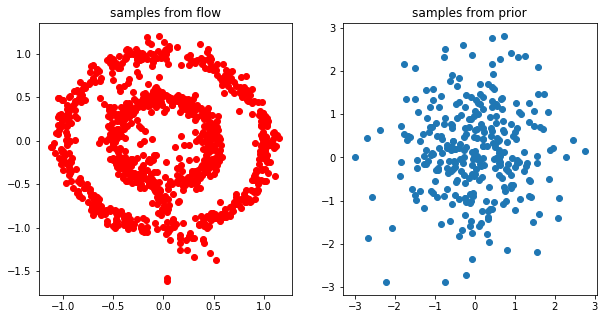

In [48]:
x = np.array(flow.sample(1000).tolist())
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(x[:,0], x[:,1], color='r')
ax.set_title('samples from flow')

x = np.array(prior.sample(torch.Size([300])).tolist())

ax = fig.add_subplot(1,2,2)

ax.scatter(x[:,0], x[:,1])
ax.set_title('samples from prior')

Text(0.5,1,'mapping from data to prior')

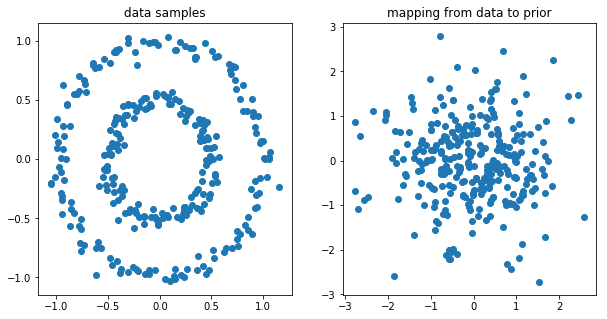

In [49]:
noisy_circles = datasets.make_circles(n_samples=300, factor=.5, noise=.05)
x = np.array(noisy_circles[0].tolist())
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(x[:,0], x[:,1])
ax.set_title('data samples')

z, det_J = flow.f(noisy_circles[0])
z = np.array(z.tolist())
ax = fig.add_subplot(1,2,2)
ax.scatter(z[:,0], z[:,1])
ax.set_title('mapping from data to prior')

## Providde answerrs for the folowing questions:

1. What architecture worked better in your experiments?


**Simple architecture with fully connected layers followed by nonlinearities. My net consists of five such layers. I found out that it's hard to learn architecture with more a lot of layers in which number of features raise. Maybe it's due to the hardness of learning new features. It seems it's more chances to learn how to perfectly use simple representation than try to learn perfect high-dimensional representation of raw objects and then use it in a simple way.**


2. Did you find what is important for stable training (initializations, nonlinearities, ...)?


**The way of training is important for stability of training, especially learning rate. Sure different initializations give different final results but training won't become stable with different initialization. So in terms of stability it's more important to choose correct way of learning. Also different architectures with the same way of learning may differ a lot in terms of stability.**


3. How convergence speed (in iterations) depends on the complexity of architecture?


**Slightly more complex architecture converge way slower and at the same time oversimplified architecture can not be able to find good optimum at all. **


# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignment.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, than use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. Expressiveness: 
- Train the flow on an another 2d-dataset e.g., a mixture of 6 Gaussians (see figure 10, https://openreview.net/pdf?id=Hkg313AcFX). Is it possible to fit it with a normalizing flow? What is more beneficial increase size of s and t or increase the depth? Provide a justification for the answer e.g. plots.
- Use the flow to sample images from a more complex dataset, e.g. downsampled MNIST (8x8 should be fine). Do your findings remains the same? Also, provide plots.
